# Object Detection inference to submission.csv

# Imports

In [1]:
import numpy as np
import os
import pandas as pd
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import sys
%matplotlib inline

## Calculate IoU :

In [2]:
def calcIOU(xmin1, ymin1, w1, h1, xmid2, ymid2, w2, h2):
    # convert (xmin, ymin) to (xmid, ymid)
    xmid1 = (xmin1 + w1/2.0)
    ymid1 = (ymin1 + h1/2.0)
    xmid2 = (xmid2 + w2/2.0)
    ymid2 = (ymid2 + h2/2.0)

    if((abs(xmid1 - xmid2) < ((w1 + w2) / 2.0)) and (abs(ymid1 - ymid2) < ((h1 + h2) / 2.0))):
        lu_x_inter = max((xmid1 - (w1 / 2.0)), (xmid2 - (w2 / 2.0)))
        lu_y_inter = min((ymid1 + (h1 / 2.0)), (ymid2 + (h2 / 2.0)))

        rd_x_inter = min((xmid1 + (w1 / 2.0)), (xmid2 + (w2 / 2.0)))
        rd_y_inter = max((ymid1 - (h1 / 2.0)), (ymid2 - (h2 / 2.0)))

        inter_w = abs(rd_x_inter - lu_x_inter)
        inter_h = abs(lu_y_inter - rd_y_inter)

        inter_square = inter_w * inter_h
        union_square = (w1 * h1) + (w2 * h2) - inter_square

        calcIOU = inter_square / union_square * 1.0
        #print("calcIOU:", calcIOU)
    else:
        #print("No intersection!")
        calcIOU = 0.0

    return calcIOU


print(calcIOU(2,2,55,77,50,75,99,65))

0.002631084382634843


In [3]:
real_data = pd.read_csv("submission/frcnn_irvac_submission_real.csv")
guess_data = pd.read_csv("/dk-jaden-frcnn/fromweb_test/frcnn_irvac_50698_submission.csv")
#guess_data = pd.read_csv("submission/frcnn_irvac_submission_real.csv")
#real_data = real_data.sort_values(by='image_filename')
#guess_data = guess_data.sort_values(by='image_filename')

real_label_group = real_data.groupby('label_id')
guess_label_group = guess_data.groupby('label_id')

guess_rank_tbs = [[] for i_label in range(0,4)]
for i_label_id in range(1,4):
    real_image_filename_group = real_label_group.get_group(i_label_id).groupby('image_filename')
    guess_image_filename_group = guess_label_group.get_group(i_label_id).groupby('image_filename')


    for image_filename in guess_image_filename_group.groups.keys():
        try:
            guess_imageBBs = guess_image_filename_group.get_group(image_filename)
            real_imageBBs = real_image_filename_group.get_group(image_filename)

        except:
            real_imageBBs = pd.DataFrame()


        for index, guess_imageBB in guess_imageBBs.iterrows():
            IoUs = [(calcIOU(guess_imageBB[2],guess_imageBB[3],guess_imageBB[4],guess_imageBB[5],real_imageBB[2],real_imageBB[3],real_imageBB[4],real_imageBB[5])) for index_r, real_imageBB in real_imageBBs.iterrows()]
            try:
                highest_IoU = max(IoUs)
                highest_IoU_idx_in_real = IoUs.index(highest_IoU)
                TP_FP = 1 if highest_IoU >= 0.5 else 0
                guess_rank_tbs[i_label_id].append([guess_imageBB[0],guess_imageBB[6],highest_IoU,TP_FP,guess_imageBB[2],guess_imageBB[3],guess_imageBB[4],guess_imageBB[5],real_imageBBs.iloc[highest_IoU_idx_in_real]['x'],real_imageBBs.iloc[highest_IoU_idx_in_real]['y'],real_imageBBs.iloc[highest_IoU_idx_in_real]['w'],real_imageBBs.iloc[highest_IoU_idx_in_real]['h']])
     
            except:
                TP_FP = 0
                highest_IoU = 'NaN'
                guess_rank_tbs[i_label_id].append([guess_imageBB[0],guess_imageBB[6],highest_IoU,TP_FP,guess_imageBB[2],guess_imageBB[3],guess_imageBB[4],guess_imageBB[5]])



    print(guess_imageBBs.head())
    print(real_imageBBs.head())
    print(highest_IoU)

     image_filename  label_id     x    y    w    h  confidence
5884    ctp_598.jpg         1   861  600  406  333    0.999619
5885    ctp_598.jpg         1  1578  625  336  273    0.999470
5887    ctp_598.jpg         1  1632  531  271  201    0.996336
5888    ctp_598.jpg         1  1220  646  153  116    0.993535
5889    ctp_598.jpg         1  1329  630  117   99    0.983159
     image_filename  label_id     x    y    w    h  confidence
3757    ctp_598.jpg         1  1584  632  336  267           1
3758    ctp_598.jpg         1  1635  535  285  203           1
3759    ctp_598.jpg         1   858  611  426  319           1
3760    ctp_598.jpg         1   186  591   69   59           1
3761    ctp_598.jpg         1   670  631  111   50           1
0.8144694811361478
     image_filename  label_id    x    y   w   h  confidence
8130    ctp_944.jpg         2  666  287  27  68    0.871899
     image_filename  label_id     x    y   w   h  confidence
6019    ctp_944.jpg         2  1099  307  30

In [4]:
for i_label in range(1,4):
    guess_rank_tbs[i_label] = sorted(guess_rank_tbs[i_label], key=lambda con:con[1],reverse=True)

In [5]:
#for i_label in range(1,4):
#    print(guess_rank_tbs[i_label][0:5],'\n')
guess_rank_tb_forDisplay = pd.DataFrame(guess_rank_tbs[1], columns = ['image_filename','confidence','IoU','TP_FP','x_Guess','y_Guess','w_Guess','h_Guess','x_Real','y_Real','w_Real','h_Real'])
guess_rank_tb_forDisplay

,image_filename,confidence,IoU,TP_FP,x_Guess,y_Guess,w_Guess,h_Guess,x_Real,y_Real,w_Real,h_Real
0,ctp_335.jpg,0.999966,0.958492,1,1226,321,693,592,1221.0,334.0,699.0,586.0
1,ctp_369.jpg,0.999961,0.956163,1,1251,303,668,641,1244.0,319.0,676.0,620.0
2,ctp_190.jpg,0.999956,0.947603,1,1266,287,653,686,1267.0,304.0,653.0,652.0
3,ctp_901.jpg,0.999956,0.93647,1,0,196,792,563,0.0,210.0,798.0,531.0
4,ctp_723.jpg,0.999955,0.948113,1,0,228,722,560,0.0,236.0,743.0,546.0
5,ctp_1234.jpg,0.999953,0.972151,1,1223,317,696,597,1222.0,327.0,698.0,582.0
6,ctp_1472.jpg,0.999952,0.873244,1,624,550,690,465,642.0,557.0,636.0,478.0
7,ctp_550.jpg,0.999952,0.940967,1,0,207,653,541,0.0,214.0,661.0,515.0
8,ctp_641.jpg,0.999950,0.897948,1,631,550,673,465,641.0,557.0,636.0,476.0
9,ctp_1039.jpg,0.999949,0.944009,1,1231,343,628,528,1221.0,358.0,632.0,511.0


## Calculate Precision & Recall

In [18]:
import itertools

PR_list = [[] for l in range(4)]
for i_label in range(1,4):
    TPpFN = len(real_label_group.get_group(i_label)) # TP+FN
    TP_Accumulation = list(itertools.accumulate([x[3] for x in guess_rank_tbs[i_label]]))
    PR_list[i_label] = [(x/(i+1),x/TPpFN) for i,x in enumerate(TP_Accumulation)]
    print(PR_list[2])
#PR_list[2]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 40, 41, 42, 43, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [53]:
PR_list = [[[]for l in range(2)] for l in range(4)]
for i_label in range(1,4):
    TPpFN = len(real_label_group.get_group(i_label)) # TP+FN
    TPpFP = 0
    TP_cnt = 0
    pre = 0
    rec = 0
    for guess_rank_tb in guess_rank_tbs[i_label]:
        TPpFP += 1  # TP+FP
        TP_cnt += guess_rank_tb[3]
        pre = TP_cnt/TPpFP
        rec = TP_cnt/TPpFN
        #print('pre:',pre)
        #print('rec:',rec)
        PR_list[i_label][0].append(pre)
        PR_list[i_label][1].append(rec)
PR_list[2]

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9827586206896551,
  0.9830508474576272,
  0.9833333333333333,
  0.9836065573770492,
  0.9838709677419355,
  0.9841269841269841,
  0.984375,
  0.9846153846153847,
  0.9848484848484849,
  0.9701492537313433,
  0.9705882352941176,
  0.9710144927536232,
  0.9714285714285714,
  0.9577464788732394,
  0.9583333333333334,
  0.958904109589041,
  0.9594594594594594,
  0.96,
  0.9605263157894737,
  0.961038961038961,
  0.9615384615384616,
  0.9620253164556962,
  0.9625,
  0.9629629629629629,
  0.9512195121951219,
  0.9518072289156626,
  0.9523809523809523,
  0.9529411764705882,
  0.9534883720930233,
 

## Plot P/R graph

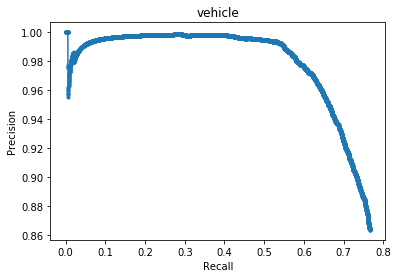

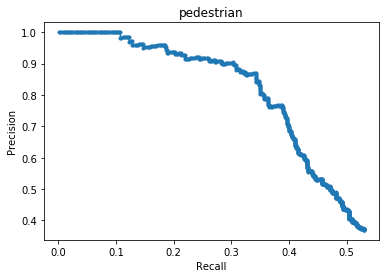

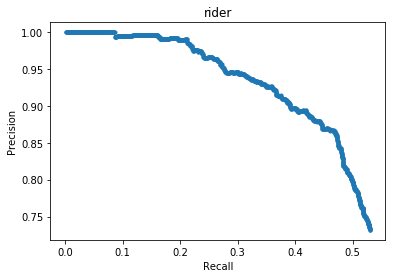

In [41]:
class_map = {1:'vehicle', 2:'pedestrian', 3:'rider'}
for i_label in range(1,4):
    fig = plt.figure()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(class_map[i_label])
    plt.plot(PR_list[i_label][1], PR_list[i_label][0],'.-')
    #print(len(PR_list[i_label][0]),len(PR_list[i_label][1]))

## Calculate mAP

In [108]:
mAP = 0
for i_label in range(1,4):
    i_start = 0
    i_end = 0
    AP = 0
    for i_mAP in range(len(PR_list[i_label][0])):
        if PR_list[i_label][0][i_mAP] < PR_list[i_label][0][i_end] or i_mAP == len(PR_list[i_label][0])-1:
            AP += PR_list[i_label][0][i_mAP-1]*(PR_list[i_label][1][i_end]-PR_list[i_label][1][i_start])
            i_start = i_end
            i_end = i_mAP
        else:
            i_end = i_mAP
    print('Class',class_map[i_label],': AP=',AP)
    mAP += AP
mAP = mAP/i_label
print('mAP=',mAP)

Class vehicle : AP= 0.7526769338625398
Class pedestrian : AP= 0.43447078532927935
Class rider : AP= 0.4978557633334445
mAP= 0.5616678275084213
